In [1]:
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *
from qiskit.tools.jupyter import *
import pprint
from qiskit.tools.monitor import backend_overview, backend_monitor
from qiskit.aqua.algorithms import Shor, Grover 
from qiskit.circuit.random import random_circuit
from qiskit.ignis.mitigation.measurement import *

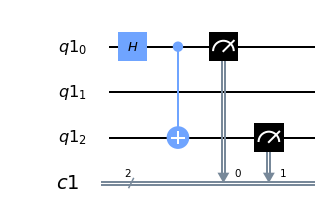

In [3]:
qr = QuantumRegister(3)
cr = ClassicalRegister(2)
circuit = QuantumCircuit(qr, cr)

circuit.h(qr[0])
circuit.cx(qr[0], qr[2])
circuit.measure(qr[0], cr[0])
circuit.measure(qr[2], cr[1])

circuit.draw(output='mpl')

In [6]:
provider = IBMQ.load_account()
real_backend = provider.get_backend('ibmq_16_melbourne')

C:\Users\TOMASZSTOPA\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [10]:
job = execute(circuit, backend=real_backend, shots=1024)

In [7]:
job=real_backend.retrieve_job('5d964483016e3a0018403075')
job.status()

<JobStatus.DONE: 'job has successfully run'>

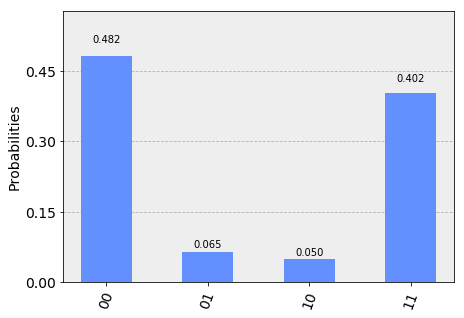

In [9]:
real_counts = job.result().get_counts()
plot_histogram(real_counts)

In [10]:
measurement_calibrations, state_labels = complete_meas_cal(qubit_list=[0,2])

In [11]:
len(measurement_calibrations)

4

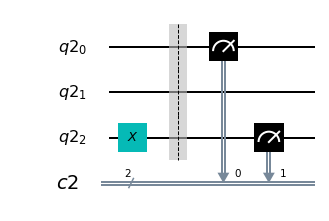

In [59]:
measurement_calibrations[2].draw(output='mpl')

In [61]:
job_calibration = execute(measurement_calibrations, backend=real_backend)

'5d964e0689988b00183f9b34'

In [15]:
job_calibration = real_backend.retrieve_job('5d964e0689988b00183f9b34')

In [16]:
calibration_results = job_calibration.result()
measurement_fitter = CompleteMeasFitter(calibration_results, state_labels)

In [17]:
print(measurement_fitter.cal_matrix)

[[0.9609375  0.04003906 0.11425781 0.01953125]
 [0.03613281 0.95898438 0.00585938 0.109375  ]
 [0.00195312 0.         0.84375    0.05273438]
 [0.00097656 0.00097656 0.03613281 0.81835938]]


In [18]:
print(measurement_fitter.readout_fidelity())

0.8955078125


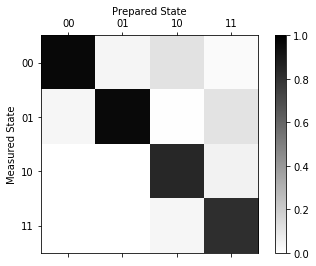

In [19]:
measurement_fitter.plot_calibration()

In [20]:
measurement_filter = measurement_fitter.filter
mitigated_counts = measurement_filter.apply(real_counts)

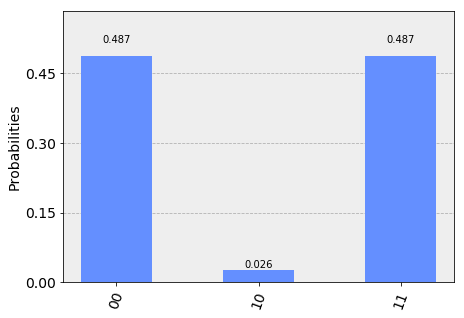

In [21]:
plot_histogram(mitigated_counts)

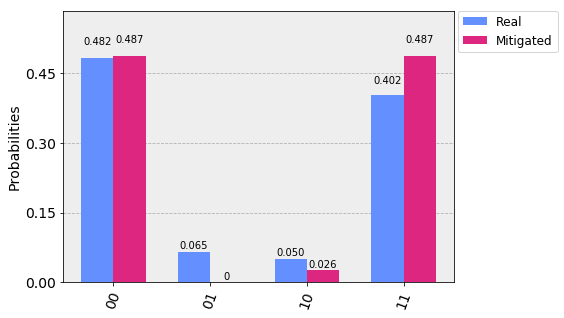

In [22]:
plot_histogram([real_counts, mitigated_counts], legend=["Real", "Mitigated"])

In [40]:
print(real_counts)

{'10': 51, '11': 412, '01': 67, '00': 494}


In [41]:
real_counts_vector = [494, 67, 51, 412]
print(real_counts_vector)

[494, 67, 51, 412]


In [44]:
import scipy.linalg as la

inverted_matrix = la.pinv(measurement_fitter.cal_matrix)
print(inverted_matrix)

[[ 1.04258245e+00 -4.35192106e-02 -1.40451913e-01 -1.00156254e-02]
 [-3.91435496e-02  1.04454564e+00  3.99638230e-03 -1.38928454e-01]
 [-2.34501766e-03  1.75883163e-04  1.18878062e+00 -7.65715420e-02]
 [-1.09388216e-03 -1.20230800e-03 -5.23250925e-02  1.22551562e+00]]


In [62]:
import numpy as np

corrected_vector = np.dot(inverted_matrix, real_counts_vector) / 1024

print(corrected_vector)

[ 0.48909224 -0.00623737  0.02727899  0.48986614]


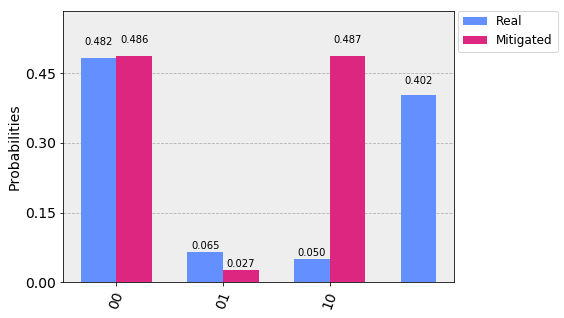

In [61]:
plot_histogram([real_counts, mitigated_counts], legend=["Real", "Mitigated"])

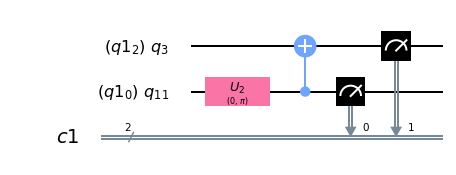

In [25]:
final_circuit = transpile(circuit, real_backend, optimization_level=3)
final_circuit.draw(output='mpl', idle_wires=False)

In [26]:
job_final = execute(final_circuit, backend=real_backend, shots=5000)

In [27]:
job_final.job_id()

'5de4315b297c5a00116f3170'

In [51]:
job_final.queue_position()

0

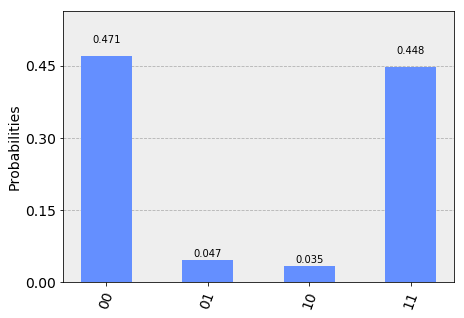

In [54]:
real_counts_final = job_final.result().get_counts()
plot_histogram(real_counts_final)

In [32]:
measurement_calibrations_final, state_labels_final = complete_meas_cal(qubit_list=[3,11])

In [33]:
job_calibration_final = execute(measurement_calibrations_final, backend=real_backend)

In [34]:
job_calibration_final.job_id()

'5de431d1a29eeb0012f6e47f'

In [52]:
job_calibration_final.queue_position()

0

In [53]:
calibration_results_final = job_calibration_final.result()
measurement_fitter_final = CompleteMeasFitter(calibration_results_final, state_labels_final)

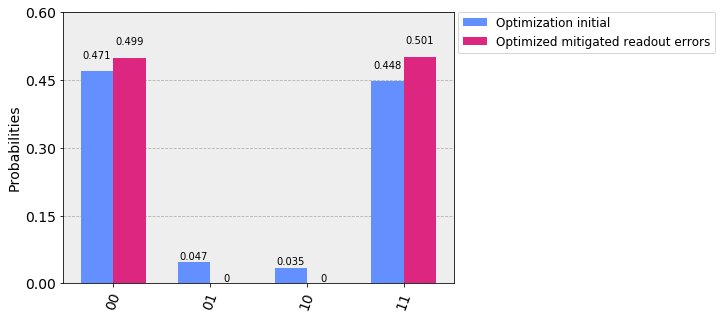

In [55]:
measurement_filter_final = measurement_fitter_final.filter
final_counts = measurement_filter_final.apply(real_counts_final)

plot_histogram([real_counts_final, final_counts], legend=["Optimization initial", "Optimized mitigated readout errors"])